In [1]:
from ai2thor.controller import Controller
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from collections import deque

In [2]:
controller = Controller(
    agentMode="arm",
    massThreshold=None,
    scene="FloorPlan1",
    visibilityDistance=1.5,
    gridSize=0.25,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=900,
    height=900,
    fieldOfView=60
)

In [3]:
# controller.reset("FloorPlan5")
# controller.step('Pass')

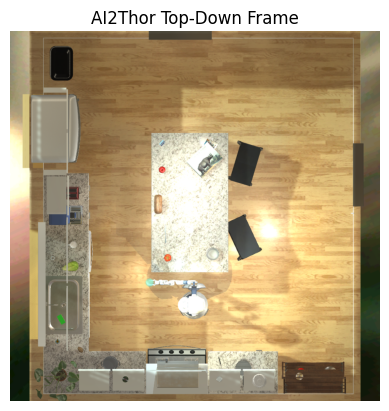

In [148]:
controller.step(action='ToggleMapView')
top_down_event = controller.last_event

# Capture the top-down view image
top_down_frame = top_down_event.frame 

# Toggle back to the original view
controller.step(action='ToggleMapView')
controller.step("Pass")
plt.imshow(top_down_frame) 
plt.axis('off') # Turn off axis labels and ticks 
plt.title('AI2Thor Top-Down Frame') 
plt.show()

In [5]:
event = controller.last_event
agent_pos = event.metadata["agent"]["position"]
floorplan = event.metadata["sceneName"]

burners = [obj for obj in event.metadata["objects"] if obj["objectType"] == "StoveBurner"]

if burners:
    mid_x = sum(b["position"]["x"] for b in burners) / len(burners)
    mid_y = sum(b["position"]["y"] for b in burners) / len(burners)
    mid_z = sum(b["position"]["z"] for b in burners) / len(burners)
    stove_pos = {"x": mid_x, "y": mid_y, "z": mid_z}
    stove_rot = burners[0]["rotation"]

    print("Floorplan:", floorplan)
    print("Agent Position:", agent_pos)
    print("Stove Position (midpoint of burners):", stove_pos)
    print("Stove Rotation (from first burner):", stove_rot)
else:
    print("No stove burners found")

Floorplan: FloorPlan1_physics
Agent Position: {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}
Stove Position (midpoint of burners): {'x': -0.25065000355243683, 'y': 0.9150999784469604, 'z': -2.4740999937057495}
Stove Rotation (from first burner): {'x': -0.0, 'y': 0.0, 'z': 0.0}


In [6]:
import threading
import ipywidgets as widgets
from IPython.display import display, clear_output

# Set your ai2thor controller
# from ai2thor.controller import Controller
# controller = Controller()

button_layout = widgets.Layout(width='100px')

# Define buttons
move_ahead_button = widgets.Button(description="Move Ahead", layout=button_layout)
rotate_left_button = widgets.Button(description="Rotate Left", layout=button_layout)
rotate_right_button = widgets.Button(description="Rotate Right", layout=button_layout)
look_up_button = widgets.Button(description="Look Up", layout=button_layout)
look_down_button = widgets.Button(description="Look Down", layout=button_layout)
confirm_button = widgets.Button(description="Confirm", layout=button_layout)

# Optional reset button
reset_button = widgets.Button(description="Reset", layout=button_layout, button_style='danger')

# Output widget
output = widgets.Output()

# Action dispatcher
def run_action(action):
    def thread_func():
        with output:
            print(f"Executing: {action}")
            try:
                event = controller.step(action=action)
                print(f"Success: {event.metadata['lastActionSuccess']}")
            except Exception as e:
                print(f"Error: {e}")
    t = threading.Thread(target=thread_func)
    t.start()

# Click handler
def on_button_click(b):
    action_map = {
        "Move Ahead": "MoveAhead",
        "Rotate Right": "RotateRight",
        "Rotate Left": "RotateLeft",
        "Look Up": "LookUp",
        "Look Down": "LookDown",
        "Confirm": "Pass",  # or a custom confirm action
        "Reset": "Reset"
    }
    action = action_map.get(b.description)
    if action:
        run_action(action)

# Connect handlers
for btn in [
    move_ahead_button, rotate_left_button, rotate_right_button,
    look_up_button, look_down_button, confirm_button, reset_button
]:
    btn.on_click(on_button_click)

# Layout
blank = widgets.Label(value="", layout=button_layout)

display(widgets.VBox([
    widgets.HBox([blank, look_up_button, blank]),
    widgets.HBox([rotate_left_button, confirm_button, rotate_right_button, move_ahead_button]),
    widgets.HBox([blank, look_down_button, blank]),
    widgets.HBox([reset_button]),
]))

display(output)


Output()

In [7]:
#TELEPORT CODE STARTS HERE 

In [99]:
controller.step(
    action="MoveArm",
    position={"x": 0.0, "y": 0.7, "z": 0.5},  # y higher, z zero to point arm up
    coordinateSpace="armBase",
    restrictMovement=False,
    speed=0.01,
    returnToStart=False,
    fixedDeltaTime=0.02,
)
controller.step('Pass')

<ai2thor.server.Event at 0x10a9a4160
    .metadata["lastAction"] = Pass
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [10]:
def snap_to_grid(pos, grid_size=0.25):
    return {'x': round(pos['x'] / grid_size) * grid_size,
            'y': pos['y'], 'z': round(pos['z'] / grid_size) * grid_size}


In [11]:
def find_closest_y(x, z, reachable_positions):
    for p in reachable_positions:
        if abs(p['x'] - x) < 1e-3 and abs(p['z'] - z) < 1e-3:
            return p['y']
    return None

In [12]:
def pos_check(target_pos, positions, tolerance=0.1):
    for pos in positions:
        dx = abs(pos['x'] - target_pos['x'])
        dz = abs(pos['z'] - target_pos['z'])
        if dx <= tolerance and dz <= tolerance:
            return True
    return False

In [13]:
def pos_key(pos):
    return (round(pos['x'], 3), round(pos['z'], 3))

In [14]:
def bfs_around_target(target_pos, positions, grid_size=0.25):
    visited = set()
    q = deque([target_pos])
    directions = [
        {'x': -grid_size, 'z': 0}, {'x': grid_size, 'z': 0},
        {'x': 0, 'z': grid_size}, {'x': 0, 'z': -grid_size}
    ]
    while q:
        curr = q.popleft()
        for d in directions:
            next_pos = {'x': round(curr['x'] + d['x'], 3), 'y': target_pos['y'], 'z': round(curr['z'] + d['z'], 3)}
            next_next_pos = {'x': round(curr['x'] + 2 * d['x'], 3), 'y': target_pos['y'], 'z': round(curr['z'] + 2 * d['z'], 3)}
            if pos_key(next_next_pos) not in visited:
                visited.add(pos_key(next_next_pos))
                q.append(next_pos)
                if pos_check(next_pos, positions) and pos_check(next_next_pos, positions):
                    return next_next_pos
    return None

reachable = controller.step("GetReachablePositions").metadata["actionReturn"]
target_obj = next(obj for obj in controller.last_event.metadata['objects'] if "Stove" in obj['objectType'])
target_obj['position'] = snap_to_grid(target_obj['position'])
target_obj['rotation']['y'] -= 180

nearest_valid = bfs_around_target(target_obj["position"], reachable)
print("Valid teleport location:", nearest_valid)

if nearest_valid:
    closest_y = find_closest_y(nearest_valid['x'], nearest_valid['z'], reachable)
    if closest_y is not None:
        nearest_valid['y'] = closest_y
    controller.step(action="MoveArmBase", y=0.5, speed=1, returnToStart=True, fixedDeltaTime=0.02)
    controller.step(
        action="MoveArm",
        position={"x": 0.0, "y": 0.7, "z": 0.0},  # arm pointing upward (safe position)
        coordinateSpace="armBase",
        restrictMovement=False,
        speed=0.01,
        returnToStart=False,
        fixedDeltaTime=0.02,
    )
    print("Teleporting...")
    rotation_y = round((target_obj['rotation']['y'] + 360) % 360 / 90) * 90 % 360
    event = controller.step(
        action="Teleport",
        position=nearest_valid,
        rotation={"x": 0, "y": rotation_y, "z": 0}
    )
    if not event.metadata["lastActionSuccess"]:
        print("False teleport.")
else:
    print("No valid teleport location.")

controller.step('Pass')
event = controller.step("Pass")
stove_knob = next((obj for obj in event.metadata["objects"] if obj["objectType"] == "StoveKnob"), None)

if stove_knob:
    dx = stove_knob["position"]["x"] - event.metadata["agent"]["position"]["x"]
    dz = stove_knob["position"]["z"] - event.metadata["agent"]["position"]["z"]
    angle_rad = math.atan2(dx, dz)
    angle_deg = (math.degrees(angle_rad) + 360) % 360
    rounded_angle = round(angle_deg / 90) * 90 % 360
    print(f"Stove knob is at approx. {rounded_angle}° relative to agent")
    controller.step(action="Teleport", rotation={"x": 0, "y": rounded_angle, "z": 0})
else:
    print("No stove knob found in metadata.")

controller.step("LookDown")
controller.step("Pass")

Valid teleport location: {'x': 0.0, 'y': 0.9150999784469604, 'z': -1.5}
Teleporting...
Stove knob is at approx. 180° relative to agent


<ai2thor.server.Event at 0x10836a5b0
    .metadata["lastAction"] = Pass
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [15]:
controller.step('Pass')

<ai2thor.server.Event at 0x10836c850
    .metadata["lastAction"] = Pass
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [16]:
# # (Hard-coded) to env1 (Pathfinding Algorithm Needed)
# def navStove(controller):
#     controller.step("RotateLeft")
#     for i in range(10):
#         controller.step("MoveAhead")
#     controller.step("RotateLeft")
#     for i in range(3):
#         controller.step("MoveAhead")
#     controller.step("RotateRight")
#     controller.step("LookDown")
#     controller.step("MoveAhead")
#     controller.step("MoveAhead")
#     controller.step('Pass')

# # Conditional check for arm spacing and toggling
# def get_closest_toggleable_object(controller, radius=0.05):
#     hand_pos = controller.last_event.metadata["arm"]["handSphereCenter"]
    
#     def dist(obj):
#         obj_pos = obj["position"]
#         return np.linalg.norm([
#             obj_pos["x"] - hand_pos["x"],
#             obj_pos["y"] - hand_pos["y"],
#             obj_pos["z"] - hand_pos["z"]
#         ])

#     toggleable_objects = [
#         obj for obj in controller.last_event.metadata["objects"]
#         if obj["visible"] and obj["toggleable"]
#     ]

#     if not toggleable_objects:
#         return None

#     # Sort by distance to hand
#     closest_obj = min(toggleable_objects, key=dist)

#     if dist(closest_obj) < radius:
#         return closest_obj["objectId"]
#     else:
#         return None

# # (Hard-coded) Sets enviroment into a dangerous state
# def turnOnStove(controller):
#     event = controller.step(action="Pass")
#     for obj in event.metadata["objects"]:
#         if (obj["visible"] and (obj["objectType"] == "StoveKnob")):
#             print(obj["objectId"], obj["objectType"], obj["position"])
#             controller.step(action="ToggleObjectOn", objectId=obj["objectId"])
#             controller.step('Pass')

# # (Hard-coded) Conditional check for arm spacing and toggling (RL Model Needed)
# def turnOffStove(controller):
#     event = controller.last_event
#     print(event.metadata["arm"]["handSphereCenter"])
#     controller.step(
#         action="MoveArm",
#         position={'x': -0.55, 'y': 0, 'z': 0.5},
#         coordinateSpace="armBase",
#         restrictMovement=False,
#         speed=1,
#         returnToStart=True,
#         fixedDeltaTime=0.02
#     )
#     controller.step('Pass')
#     time.sleep(2)
#     event = controller.last_event
#     print(event.metadata["arm"]["handSphereCenter"])

#     obj_id = get_closest_toggleable_object(controller)
#     if obj_id:
#         event = controller.step(action="ToggleObjectOff", objectId=obj_id)
#         controller.step('Pass')
#         print("Toggled", obj_id, "Success?", event.metadata["lastActionSuccess"])
#     else:
#         print("No toggleable object close enough to hand.")
#     controller.step('Pass')

# # Shows map of the enviroment and labels of the objects
# def showMap(controller):
#     positions = controller.step(action="GetReachablePositions")
#     x_vals = [pos['x'] for pos in positions.metadata["actionReturn"]]
#     z_vals = [pos['z'] for pos in positions.metadata["actionReturn"]]

#     # Made a temp list to store objects labels
#     objlist = []
#     for obj in positions.metadata['objects']:
#         objlist.append((obj['objectType'], obj['position']))

#     x_values = [obj[1]['x'] for obj in objlist]
#     z_values = [obj[1]['z'] for obj in objlist]
#     labels = [obj[0] for obj in objlist]

#     # Plot maker
#     plt.figure(figsize=(8, 8))
#     plt.xlim(-2.5, max(x_values) + 1)
#     plt.ylim(min(z_values)-0.5, max(z_values)+0.5)  
#     plt.scatter(x_vals, z_vals, c='blue', marker='s')
#     for i, label in enumerate(labels):
#         plt.annotate(label, (x_values[i], z_values[i]), textcoords="offset points", xytext=(5,5), ha='left')
#     plt.title("Reachable Positions (x-z grid)")
#     plt.xlabel("X")
#     plt.ylabel("Z")
#     plt.grid(True)
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()

# #(WIP Teleport)
# def teleport_to_stove(controller):

#     positions = controller.step(action="GetReachablePositions")

#     objlist = []
#     target_obj = None
#     for obj in positions.metadata['objects']:
#         if "Stove" in obj['objectType']:
#             objlist.append(obj)
#             target_obj = obj
#             break

    
#     controller.step("Pass")
#     if target_obj is not None:
#         controller.step(
#             action="Teleport",
#             position=target_obj['position']
#         )

#     controller.step("Pass")


# #TESTING AREA!! CAUTION EVERYTHING BREAKS (T⌓T)
# controller = init_Agent()
# teleport_to_stove(controller)
# input("PRESS ANY KEY TO STOP!")

Executing: RotateRight
Success: True
Executing: Pass
Success: True
Executing: RotateLeft
Success: True
Executing: Pass
Success: True
Executing: RotateRight
Success: True
Executing: Pass
Success: True
